In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('../../lib')
from local_paths import analysis_dir
from hier_group import unpack_hier_names

# Parameters

In [2]:
#============================================================================
# analysis type and result path
#============================================================================
rf_fit_group = 'rf_fit/opt/per_split'  # formatted as in the rf_gaussian_fit script
# rf_fit_group = 'rf_fit/opt/across_splits'
results_subdir = 'feat_corr_map-hg-fix-rf_fit'

#============================================================================
# selection criteria
#============================================================================
rf_fit_thres = {'rf_at_fit_peak': 0.04, 'goodness_of_fit': 0.7, 'fit_coverage': 0.5}

# Preamble

In [3]:
results_dir = Path(analysis_dir+results_subdir).expanduser()
assert results_dir.is_dir()

cols_to_save = ['x', 'y', 'r', 'goodness_of_fit', 'rf_fit_weighted_mean', 'a', 'b', 'ang_rad']

# Load data

In [4]:
df = []
has_split = None
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f['progress_report/rf_fit/all_done'][()]
        except (KeyError, AssertionError):
            continue

    rf_fit_ds = xr.load_dataset(fp, group=rf_fit_group)
    with h5.File(fp, 'r') as f:
        rf_unit_names = f['rf_fit/unit_names'][()].astype(str)
    rf_fit_data = rf_fit_ds['data'].loc[{'unit':rf_unit_names}]

    if has_split is None:
        has_split = 'split' in rf_fit_data.dims
    else:
        assert has_split == ('split' in rf_fit_data.dims)

    # reshape data; ensure only one condition exists
    dims_ = tuple(set(rf_fit_data.dims) - {'unit','feature','split'})
    assert np.prod([rf_fit_data.coords[d].size for d in dims_]) == 1
    if has_split:
        new_dims = dims_ + ('split', 'unit', 'feature')
    else:
        new_dims = dims_ + ('unit', 'feature')
    rf_fit_data = rf_fit_data.transpose(*new_dims)

    # reformat as dataframe
    data = rf_fit_data.values.reshape(-1, rf_fit_data.shape[-1])
    rf_df = pd.DataFrame(data=data, columns=rf_fit_data.coords['feature'].astype(str))
    index = unpack_hier_names(rf_unit_names)
    if has_split:
        rf_df['Split'] = rf_fit_data['split'].broadcast_like(rf_fit_data.isel(feature=0)).values.ravel()
        rf_df[['Level', 'Name']] = np.concatenate([index]*rf_fit_data['split'].size, axis=0)
    else:
        rf_df[['Level', 'Name']] = index
    rf_df['Session'] = fp.stem
    df.append(rf_df)

df = pd.concat(df)
if has_split:
    df = df.set_index(['Session', 'Level', 'Name', 'Split'])
else:
    df = df.set_index(['Session', 'Level', 'Name'])
assert not df.index.has_duplicates
df['r'] = np.sqrt(np.prod(df[['a', 'b']], axis=1))
print(df.shape)

output_sfx = ('-across_splits', '')[has_split]

(387105, 12)


# Select from all results

In [5]:
def select_rf_fit(rf_df, rf_fit_thres=rf_fit_thres):
    criteria = {}
    criteria['Is valid'] = np.isfinite(rf_df[list('xyab')].values).all(1)
    for k, v in rf_fit_thres.items():
        criteria[k] = rf_df[k] >= v

    print(f'Selecting from {len(rf_df)} entries')
    for k, m in criteria.items():
        print(f'criterion: {k:<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')
    m = np.all(list(criteria.values()), axis=0)
    print(f'criterion: {"All":<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')

    return m

In [6]:
rf_df = df.copy()
rf_df['Selected'] = select_rf_fit(rf_df)

Selecting from 387105 entries
criterion: Is valid             passed: 95.9% (371353 of 387105)
criterion: rf_at_fit_peak       passed: 26.6% (102879 of 387105)
criterion: goodness_of_fit      passed: 70.5% (272859 of 387105)
criterion: fit_coverage         passed: 74.0% (286591 of 387105)
criterion: All                  passed: 22.9% (88739 of 387105)


In [7]:
rf_df.loc[rf_df['Selected'], cols_to_save].to_csv(
    f'summary/rf_fit{output_sfx}.csv.gz')

# Summarize array-level results

In [8]:
arreg = pd.read_csv('../../db/bank_array_regions.csv').astype({'Array ID': str})
arreg['Subject'] = [v[:2] for v in arreg['Session']]
arreg = arreg.groupby(['Subject', 'Array ID']).first()

In [9]:
rf_df = df.reset_index()
rf_df = rf_df[rf_df['Level']=='Array'].copy()
rf_df['Selected'] = select_rf_fit(rf_df)

Selecting from 2265 entries
criterion: Is valid             passed: 96.4% (2184 of 2265)
criterion: rf_at_fit_peak       passed: 53.3% (1207 of 2265)
criterion: goodness_of_fit      passed: 84.2% (1907 of 2265)
criterion: fit_coverage         passed: 75.5% (1711 of 2265)
criterion: All                  passed: 46.3% (1048 of 2265)


In [10]:
adf = rf_df[rf_df['Selected']].copy()
adf['Subject'] = [v[:2] for v in adf['Session']]
adf[['Region', 'Hemisphere']] = arreg.loc[list(map(tuple, adf[['Subject', 'Name']].values))][['Region', 'Hemisphere']].values

Array-level RF fit, per session


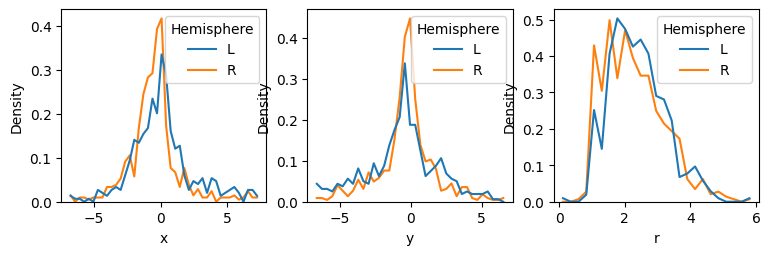

In [11]:
print('Array-level RF fit, per session')
fig, axs = plt.subplots(1, 3, figsize=(9,2.5))
for x, ax in zip('xyr', axs):
    sns.histplot(
        data=adf, x=x, hue='Hemisphere', hue_order=('L','R'),
        stat='density', element='poly', common_norm=False, fill=False, ax=ax)

Array-level estimates, median across sessions


Region Hemisphere  Selected         x         y         r   
Subject Name                                                             
Bf      0       AIT          L       1.0 -0.077252 -2.835543  2.239409  \
        5       CIT          R       1.0 -0.454931 -2.173038  1.843280   
        6       AIT          R       1.0  0.436152  3.251816  1.514966   
        8       AIT          R       1.0 -0.720118  2.373397  2.965685   
Bo      3       AIT          R       1.0 -0.332995 -0.754186  2.474683   
Fr      0       CIT          R       1.0 -0.027870  0.077130  2.121050   
        1       CIT          L       1.0 -1.300669 -0.481590  2.109563   
        2       AIT          L       1.0 -0.649507 -0.421722  3.066787   
Lo      2       CIT          L       1.0  0.524741  0.312103  2.126759   
Na      2       AIT          L       1.0 -0.097190 -0.439254  3.232892   
        3       AIT          L       1.0  2.916739  2.062436  2.425890   
Oc      6       AIT          L       1.0  0.131921 -0.124911  2.224233   
        7       AIT          R       1.0  0.030522  1.378174  2.725179   
Ot      6       CIT          R       1.0 -0.648901 -0.149673  0.776344   
        7       AIT          R       1.0  2.169773  1.741831  1.400039   
Re      6       AIT          L       1.0  0.371586 -1.744557  2.683512   
Sw      1       CIT          L       1.0 -0.478713  1.047803  2.037891   
Ve      2       AIT          R       1.0 -0.774658 -0.074025  1.912012   
        3       AIT          R       1.0 -0.801089 -0.003296  2.205652   

              goodness_of_fit  rf_fit_weighted_mean         a         b   
Subject Name                                                              
Bf      0            0.930819              0.033673  2.266819  2.390893  \
        5            0.832190              0.152820  2.992086  0.989011   
        6            0.748103              0.149388  2.468076  1.228377   
        8            0.917288              0.042519  4.333184  2.029752   
Bo      3            0.923270              0.117395  2.904474  2.123453   
Fr      0            0.956667              0.058907  2.188453  1.615377   
        1            0.916618              0.068986  2.355848  1.991003   
        2            0.917534              0.074380  3.471210  2.080695   
Lo      2            0.950356              0.043899  2.778698  1.380340   
Na      2            0.902476              0.033166  3.890825  2.325858   
        3            0.862620              0.034143  4.184966  1.432047   
Oc      6            0.928039              0.047191  2.599314  1.968307   
        7            0.921456              0.026329  3.453456  2.287129   
Ot      6            0.707719              0.055275  4.262505  0.141398   
        7            0.813018              0.064134  1.565017  1.252453   
Re      6            0.921873              0.094960  2.987867  2.352197   
Sw      1            0.868749              0.068478  2.617385  1.473709   
Ve      2            0.927013              0.059228  2.032100  1.724346   
        3            0.929999              0.046056  2.634503  1.901782   

               ang_rad  
Subject Name            
Bf      0     1.777506  
        5     3.221889  
        6     1.600326  
        8     2.523653  
Bo      3     2.649383  
Fr      0     2.850630  
        1     2.246256  
        2     1.879024  
Lo      2     3.127467  
Na      2     3.140189  
        3     2.284445  
Oc      6     3.108900  
        7     3.011554  
Ot      6     1.366416  
        7     3.127619  
Re      6     2.625749  
Sw      1     2.993037  
Ve      2     2.990793  
        3     3.121522

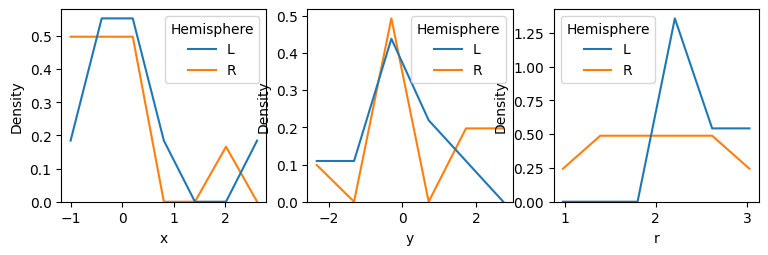

In [12]:
print('Array-level estimates, median across sessions')
df_ = adf.groupby(['Subject','Name']).agg({
    'Region': 'first', 'Hemisphere': 'first', 'Selected': 'mean',
    **{k: 'median' for k in cols_to_save}})
assert df_['Selected'].all()  # sanity check
fig, axs = plt.subplots(1, 3, figsize=(9,2.5))
for i, (x, ax) in enumerate(zip('xyr', axs)):
    sns.histplot(data=df_, x=x, hue='Hemisphere', stat='density', element='poly', common_norm=False, fill=False, ax=ax)
df_

In [13]:
print('Array-level estimates, median across arrays')
df_.groupby(['Region', 'Hemisphere']).median()

Array-level estimates, median across arrays


Selected         x         y         r  goodness_of_fit   
Region Hemisphere                                                            
AIT    L                1.0  0.027335 -0.430488  2.554701         0.919703  \
       R                1.0 -0.332995  1.378174  2.205652         0.921456   
CIT    L                1.0 -0.478713  0.312103  2.109563         0.916618   
       R                1.0 -0.454931 -0.149673  1.843280         0.832190   

                   rf_fit_weighted_mean         a         b   ang_rad  
Region Hemisphere                                                      
AIT    L                       0.040667  3.229539  2.203277  2.455097  
       R                       0.059228  2.634503  1.901782  2.990793  
CIT    L                       0.068478  2.617385  1.473709  2.993037  
       R                       0.058907  2.992086  0.989011  2.850630

In [14]:
# save array-level resuilts median across sessions
gb = adf.groupby(['Subject', 'Name'])
df_ = gb[cols_to_save].median()
df_['Count'] = gb['x'].count()
df_[['Region', 'Hemisphere']] = gb[['Region', 'Hemisphere']].first()
df_['Level'] = 'Array'
df_ = df_.reset_index().set_index(['Subject', 'Level', 'Name'])
df_.to_csv(f'summary/rf_fit{output_sfx}-array_level.csv.gz')
df_

x         y         r  goodness_of_fit   
Subject Level Name                                                  
Bf      Array 0    -0.077252 -2.835543  2.239409         0.930819  \
              5    -0.454931 -2.173038  1.843280         0.832190   
              6     0.436152  3.251816  1.514966         0.748103   
              8    -0.720118  2.373397  2.965685         0.917288   
Bo      Array 3    -0.332995 -0.754186  2.474683         0.923270   
Fr      Array 0    -0.027870  0.077130  2.121050         0.956667   
              1    -1.300669 -0.481590  2.109563         0.916618   
              2    -0.649507 -0.421722  3.066787         0.917534   
Lo      Array 2     0.524741  0.312103  2.126759         0.950356   
Na      Array 2    -0.097190 -0.439254  3.232892         0.902476   
              3     2.916739  2.062436  2.425890         0.862620   
Oc      Array 6     0.131921 -0.124911  2.224233         0.928039   
              7     0.030522  1.378174  2.725179         0.921456   
Ot      Array 6    -0.648901 -0.149673  0.776344         0.707719   
              7     2.169773  1.741831  1.400039         0.813018   
Re      Array 6     0.371586 -1.744557  2.683512         0.921873   
Sw      Array 1    -0.478713  1.047803  2.037891         0.868749   
Ve      Array 2    -0.774658 -0.074025  1.912012         0.927013   
              3    -0.801089 -0.003296  2.205652         0.929999   

                    rf_fit_weighted_mean         a         b   ang_rad  Count   
Subject Level Name                                                              
Bf      Array 0                 0.033673  2.266819  2.390893  1.777506      5  \
              5                 0.152820  2.992086  0.989011  3.221889      5   
              6                 0.149388  2.468076  1.228377  1.600326      4   
              8                 0.042519  4.333184  2.029752  2.523653      3   
Bo      Array 3                 0.117395  2.904474  2.123453  2.649383    238   
Fr      Array 0                 0.058907  2.188453  1.615377  2.850630    116   
              1                 0.068986  2.355848  1.991003  2.246256     79   
              2                 0.074380  3.471210  2.080695  1.879024     16   
Lo      Array 2                 0.043899  2.778698  1.380340  3.127467     52   
Na      Array 2                 0.033166  3.890825  2.325858  3.140189     23   
              3                 0.034143  4.184966  1.432047  2.284445      2   
Oc      Array 6                 0.047191  2.599314  1.968307  3.108900     50   
              7                 0.026329  3.453456  2.287129  3.011554      3   
Ot      Array 6                 0.055275  4.262505  0.141398  1.366416      1   
              7                 0.064134  1.565017  1.252453  3.127619      1   
Re      Array 6                 0.094960  2.987867  2.352197  2.625749    130   
Sw      Array 1                 0.068478  2.617385  1.473709  2.993037     80   
Ve      Array 2                 0.059228  2.032100  1.724346  2.990793    129   
              3                 0.046056  2.634503  1.901782  3.121522    111   

                   Region Hemisphere  
Subject Level Name                    
Bf      Array 0       AIT          L  
              5       CIT          R  
              6       AIT          R  
              8       AIT          R  
Bo      Array 3       AIT          R  
Fr      Array 0       CIT          R  
              1       CIT          L  
              2       AIT          L  
Lo      Array 2       CIT          L  
Na      Array 2       AIT          L  
              3       AIT          L  
Oc      Array 6       AIT          L  
              7       AIT          R  
Ot      Array 6       CIT          R  
              7       AIT          R  
Re      Array 6       AIT          L  
Sw      Array 1       CIT          L  
Ve      Array 2       AIT          R  
              3       AIT          R